In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy.stats as st
from IPython.display import display, Markdown

from common_plotting import read_data, plot, years, months, yearsFmt, add_thp

In [166]:
def analyse_dcv(absolute_data, relative_data):
    absolute_results, absolute_ratios_in_ppm = analyse_dcv_absolute(absolute_data, 'D4910avg', 'ag3458a_1')
    f7001_value = absolute_results[absolute_results.index == 'F7001bat'][['dcv_mean']].iloc[0,0]
    relative_results_in_ppm = analyse_dcv_relative(relative_data, 'F7001bat', f7001_value, 'D4910avg','ag3458a_1')
    return dcv_combine_absolute_and_relative(absolute_ratios_in_ppm, relative_results_in_ppm)

def dcv_combine_absolute_and_relative(ratios_ppm, relative_results_in_ppm):
    combined = ratios_ppm.join(relative_results_in_ppm)
    combined.columns = ['temperature', 'abs_mean', 'abs_sem', 'rel_mean', 'rel_sem']
    return combined

def analyse_dcv_relative(relative_data, reference_name, reference_value, new_reference_name, meter):
    relative_dcv_add_polarity(relative_data, reference_name, meter)
    relative_results_in_ppm = relative_results_to_ppm(relative_data, reference_name, reference_value, new_reference_name)
    return relative_results_in_ppm


def analyse_dcv_absolute(absolute_data, reference_name, meter):
    absolute_data_with_groups = add_dut_and_setting_group(absolute_data)
    #display(analyse_group_quality(absolute_data_with_groups, f'{meter}_dcv'))
    absolute_data_first_and_last_in_group_removed = clean_groups(absolute_data_with_groups)
    cleaned_absolute_data = aggregate_absolute_data_by_group(absolute_data_first_and_last_in_group_removed, meter)
    absolute_grouped_by_dut_group = aggregate_absolute_data_by_dut_group(cleaned_absolute_data, meter)
    absolute_results = absolute_grouped_by_dut_group.groupby('dut').agg({'dcv_mean': 'mean', 'dcv_sem': combine_stds_sum, 'temperature_mean': 'mean'})
    ratios_from_absolute = dcv_calculate_ratios(absolute_grouped_by_dut_group, reference_name)
    ratios_in_ppm = absolute_results_to_ppm(ratios_from_absolute)
    return absolute_results, ratios_in_ppm

def combine_stds_sum(stds):
    return np.sqrt(np.sum(stds**2) / np.size(stds))

def combine_stds_ratio_product(product_or_ration_value, mean1, sem1, mean2, sem2):
    return np.abs(product_or_ration_value) * np.sqrt((sem1 / mean1)**2 + (sem2 / mean2)**2)

def add_dut_and_setting_group(data):
    data_groups = (data[['dut', 'dut_setting']].apply(tuple, axis=1) != data[['dut', 'dut_setting']].shift().apply(tuple, axis=1)).cumsum().rename('group')
    return data.join(data_groups)

def std_minus_first(series):
    return np.std(series.iloc[:-1])

def std_minus_last(series):
    return np.std(series.iloc[1:])

def analyse_group_quality(data, column):
    return absolute_data_with_groups.groupby('group').agg({column: ['std', std_minus_first, std_minus_last]})

def clean_groups(data):
    return data.groupby('group').apply(lambda x: x.iloc[1:-1]).droplevel(0)

def aggregate_absolute_data_by_group(data, meter):
    return data.groupby('group').agg({f'{meter}_dcv': ['mean', 'std', 'sem', 'count'], 'temperature': ['mean', 'std', 'sem', 'count'], 'dut': 'last', 'dut_setting': 'last', 'datetime': 'mean'})

def aggregate_absolute_data_by_dut_group(absolute_dcv_data, meter):
    data_with_dut_group = absolute_dcv_data.copy()
    # display(absolute_dcv_data)
    data_with_dut_group['dut_group'] = (data_with_dut_group['dut']['last'] != data_with_dut_group['dut']['last'].shift(1)).cumsum()
    # display(    data_with_dut_group)
    # display((data_with_dut_group['dut']['last'] != data_with_dut_group['dut']['last'].shift(-1)))
    data_with_dut_group.columns = ['_'.join(col) for col in data_with_dut_group.columns.values]
    data_grouped_by_dut = data_with_dut_group.groupby('dut_group_').agg(
        {'dut_last': 'last', f'{meter}_dcv_mean': lambda v: np.mean(np.abs(v)), (f'{meter}_dcv_sem'): combine_stds_sum, 'temperature_mean': 'mean', 'datetime_mean': 'mean'})
    data_grouped_by_dut.columns = ['dut', 'dcv_mean', 'dcv_sem', 'temperature_mean', 'datetime']
    # display(data_grouped_by_dut)
    # display(    data_with_dut_group)
    return data_grouped_by_dut


def dcv_calculate_ratios(grouped_by_dut, reference):
    befores = grouped_by_dut.shift(1)
    second_befores = grouped_by_dut.shift(2)
    afters = grouped_by_dut.shift(-1)
    second_afters = grouped_by_dut.shift(-2)
    data_with_before_and_after = grouped_by_dut.join(befores[befores.dut == 'D4910avg'], rsuffix='_before').join(afters[afters['dut'] == 'D4910avg'], rsuffix='_after')
    ratio_input = data_with_before_and_after[data_with_before_and_after.dut != 'D4910avg']

    ratios_before_input = ratio_input[~ratio_input.dut_before.isna()].copy()
    ratios_before_input['ratio'] = ratios_before_input.dcv_mean / ratios_before_input.dcv_mean_before
    ratios_before_input['ratio_sem'] = combine_stds_ratio_product(ratios_before_input.ratio, ratios_before_input.dcv_mean, ratios_before_input.dcv_sem,
                                                                  ratios_before_input.dcv_mean_before, ratios_before_input.dcv_sem_before)

    ratios_after_input = ratio_input[~ratio_input.dut_after.isna()].copy()
    ratios_after_input['ratio'] = ratios_after_input.dcv_mean / ratios_after_input.dcv_mean_after
    ratios_after_input['ratio_sem'] = combine_stds_ratio_product(ratios_after_input.ratio, ratios_after_input.dcv_mean, ratios_after_input.dcv_sem,
                                                                 ratios_after_input.dcv_mean_after, ratios_after_input.dcv_sem_after)

    ratios_before_and_after = pd.concat(
        [ratios_before_input[['dut', 'ratio', 'ratio_sem', 'temperature_mean']], ratios_after_input[['dut', 'ratio', 'ratio_sem', 'temperature_mean']]])
    ratios_from_absolute = ratios_before_and_after.groupby('dut').agg({'ratio': 'mean', 'ratio_sem': combine_stds_sum, 'temperature_mean': 'mean'})
    ratios_from_absolute = pd.concat([ratios_from_absolute, pd.DataFrame({'ratio': 1, 'ratio_sem': 0, 'temperature_mean': np.nan}, index=(reference,))])
    return ratios_from_absolute


def relative_dcv_add_polarity(data, reference_name, meter):
    data['polarity'] = data.dut_neg_lead.apply(lambda dut: 'positive' if dut == reference_name else 'negative')
    data['dut'] = data.apply(lambda row: row.dut_neg_lead if row.polarity == 'negative' else row.dut_pos_lead, axis=1)
    data.loc[data['polarity'] == 'positive','corrected_value'] = data[f'{meter}_dcv']
    data.loc[data['polarity'] == 'negative','corrected_value'] = -data[f'{meter}_dcv']

def relative_results_to_ppm(relative_data, reference_name, reference_value, new_reference_name):
    grouped_by_dut_polarity = relative_data.groupby(['dut', 'polarity']).agg({'corrected_value': ['mean', 'std', 'sem', 'count']}).droplevel(0, axis=1).reset_index()
    relative_results = grouped_by_dut_polarity.groupby('dut').agg({'mean': 'mean', 'sem': combine_stds_sum})
    relative_results_in_ppm = pd.DataFrame()
    relative_results_in_ppm.index = relative_results.index
    relative_results_in_ppm['mean_in_ppm'] = (relative_results['mean'] / reference_value) * 1e6
    relative_results_in_ppm['sem_in_ppm'] = (relative_results['sem'] / reference_value) * 1e6
    relative_results_in_ppm = pd.concat([relative_results_in_ppm, pd.DataFrame({'mean_in_ppm': 0, 'sem_in_ppm': 0}, index=(reference_name,))])
    relative_results_in_ppm['mean_in_ppm'] = relative_results_in_ppm[relative_results_in_ppm.index == new_reference_name].mean_in_ppm.iloc[0]-relative_results_in_ppm.mean_in_ppm
    relative_results_in_ppm['sem_in_ppm'] = np.sqrt(relative_results_in_ppm[relative_results_in_ppm.index == new_reference_name].sem_in_ppm.iloc[0]**2+relative_results_in_ppm.sem_in_ppm**2)
    return relative_results_in_ppm

def absolute_results_to_ppm(ratios):
    ratios_ppm = ratios.copy().drop(['ratio', 'ratio_sem'], axis=1)
    ratios_ppm['ppm_diff'] = (1-ratios.ratio) * 1e6
    ratios_ppm['ppm_sem'] = ratios.ratio_sem * 1e6
    return ratios_ppm


In [3]:
thp_data, data = read_data(['ks3458a1-dcv-log.csv', 'ks3458a1-dcv-mv-log.csv'])
absolute_data_unfiltered = data['ks3458a1-dcv-log.csv']
relative_data = data['ks3458a1-dcv-mv-log.csv']

/Users/alson/projects/personal/dmm-logging/common_plotting.py:29: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data_dict = {filename: add_thp(thp_sorted, pd.read_csv(filename, parse_dates=['datetime']))


In [167]:
absolute_data_from_this_session = absolute_data_unfiltered[absolute_data_unfiltered['last_acal_1'] == '2022-08-09T22:42:58.011500']
absolute_data = absolute_data_from_this_session[absolute_data_from_this_session['dut'] != 'F7001']
analyse_dcv(absolute_data, relative_data)

,temperature,abs_mean,abs_sem,rel_mean,rel_sem
D4910-1,35.187786,-0.321278,0.009411,-0.290235,0.007593
D4910-2,35.651870,-1.694829,0.577572,-0.097546,0.007923
D4910-3,35.537879,-0.323696,0.014686,-0.468137,0.007399
D4910-4,35.175105,0.319276,0.010395,0.305701,0.007322
F7001bat,35.159267,6.240062,0.008049,6.484320,0.006513
F732a1,34.947451,-17.648101,0.008133,-17.498447,0.006980
F732a2,34.957188,23.755563,0.009924,23.861170,0.006794
F732a3,35.229418,-14.898526,0.012779,-14.788090,0.007220
D4910avg,NaN,0.000000,0.000000,0.000000,0.009211


# Absolute data

## Checking if there is a significant difference between net power and battery power

In [23]:
F7001_bat_diff_data = absolute_data_from_this_session[(absolute_data_from_this_session.index < '2022-08-09 23:11:15.475188')]

p_pos = st.ttest_ind(F7001_bat_diff_data[(F7001_bat_diff_data['dut'] == 'F7001') & (F7001_bat_diff_data['dut_setting'] == '10 V')]['ag3458a_1_dcv'], F7001_bat_diff_data[(F7001_bat_diff_data['dut'] == 'F7001bat') & (F7001_bat_diff_data['dut_setting'] == '10 V')]['ag3458a_1_dcv'])
p_neg = st.ttest_ind(F7001_bat_diff_data[(F7001_bat_diff_data['dut'] == 'F7001') & (F7001_bat_diff_data['dut_setting'] == '-10 V')]['ag3458a_1_dcv'].iloc[:-1], F7001_bat_diff_data[(F7001_bat_diff_data['dut'] == 'F7001bat') & (F7001_bat_diff_data['dut_setting'] == '-10 V')]['ag3458a_1_dcv'].iloc[:-1])

display(F7001_bat_diff_data.groupby(['dut', 'dut_setting']).aggregate({'ag3458a_1_dcv': ['count', 'mean', 'std']}))

print(f'T-test for positive measurement {p_pos}')
print(f'T-test for negative measurement {p_neg}')


ag3458a_1_dcv                         
                             count       mean           std
dut      dut_setting                                       
F7001    -10 V                  43  -9.999948  5.052029e-07
         10 V                   45   9.999948  4.240470e-07
F7001bat -10 V                  46  -9.999947  3.174842e-07
         10 V                   99  10.000009  6.122669e-04

T-test for positive measurement Ttest_indResult(statistic=-0.664222916035365, pvalue=0.5076247663395842)
T-test for negative measurement Ttest_indResult(statistic=-3.9331653542171225, pvalue=0.00017057361270788745)


Ttest_indResult(statistic=-3.6742346141747673, pvalue=0.021311641128756727)

<AxesSubplot:xlabel='datetime'>

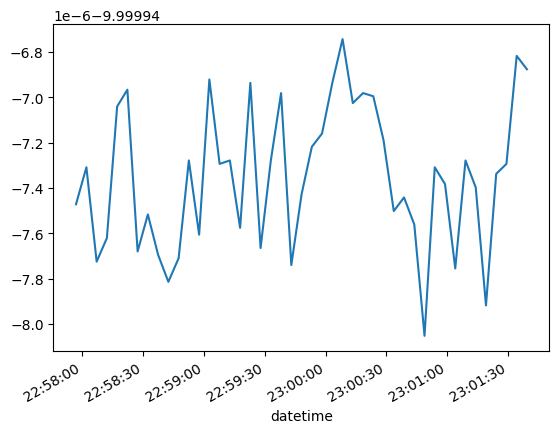

In [6]:
F7001_bat_diff_data[(F7001_bat_diff_data['dut'] == 'F7001bat') & (F7001_bat_diff_data['dut_setting'] == '-10 V')]['ag3458a_1_dcv'].iloc[:-1].plot()

<AxesSubplot:xlabel='datetime'>

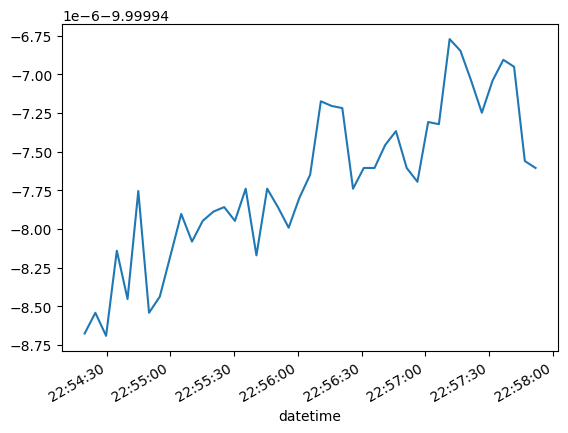

In [7]:
F7001_bat_diff_data[(F7001_bat_diff_data['dut'] == 'F7001') & (F7001_bat_diff_data['dut_setting'] == '-10 V')]['ag3458a_1_dcv'].plot()

## Absolute data

### Transform data

In [9]:
absolute_data_with_groups = add_dut_and_setting_group(absolute_data)

### Check data quality

ag3458a_1_dcv                               
                std std_minus_first std_minus_last
group                                             
1      3.174842e-07    3.166848e-07   3.169739e-07
2      6.122669e-04    4.804277e-07   6.122347e-04
3      3.632136e-07    3.600060e-07   3.630206e-07
4      2.306845e-07    2.285123e-07   2.237870e-07
5      2.686724e-07    2.661429e-07   2.686711e-07
6      3.571701e-07    3.537814e-07   3.563772e-07
7      1.481422e-04    3.603614e-07   1.479679e-04
8      3.652383e-07    3.620839e-07   3.650654e-07
9      4.061377e-07    4.059440e-07   3.498977e-07
10     5.413132e-07    5.378814e-07   5.051356e-07
11     4.018916e-05    3.015188e-07   4.013023e-05
12     3.482697e-07    3.394517e-07   3.057777e-07
13     3.604827e-07    3.596020e-07   3.586513e-07
14     3.317336e-07    3.181937e-07   2.664799e-07
15     3.187319e-07    3.121982e-07   3.175456e-07
16     4.395975e-06    3.217231e-07   4.390756e-06
17     2.698478e-07    2.696890e-07   2.643955e-07
18     2.900676e-07    2.898161e-07   2.896872e-07
19     2.769482e-07    2.751387e-07   2.680656e-07
20     3.856123e-07    3.849340e-07   3.803350e-07
21     3.987158e-07    3.968636e-07   3.957297e-07
22     6.802387e-06    3.405552e-07   6.797564e-06
23     3.800467e-07    3.416334e-07   3.766959e-07
24     2.687855e-04    4.118341e-07   2.687498e-04
25     4.099651e-07    3.924793e-07   3.633621e-07
26     3.465472e-05    3.361530e-05   3.374403e-05
27     3.106819e-07    3.038282e-07   2.878163e-07
28     2.982128e-07    2.820773e-07   2.940040e-07
29     2.255086e-04    6.433873e-07   2.251673e-04
30     4.021196e-04    2.878577e-07   4.015607e-04
31     2.542436e-07    2.531121e-07   2.503965e-07
32     5.440614e-07    5.239030e-07   5.440596e-07
33     3.697173e-07    3.660161e-07   3.555629e-07
34     4.060095e-07    4.037461e-07   4.043641e-07
35     4.021431e-07    3.960000e-07   3.831958e-07
36     4.417117e-07    4.377292e-07   4.408435e-07
37     4.321963e-07    4.284693e-07   4.246921e-07
38     2.767925e-07    2.764082e-07   2.759785e-07

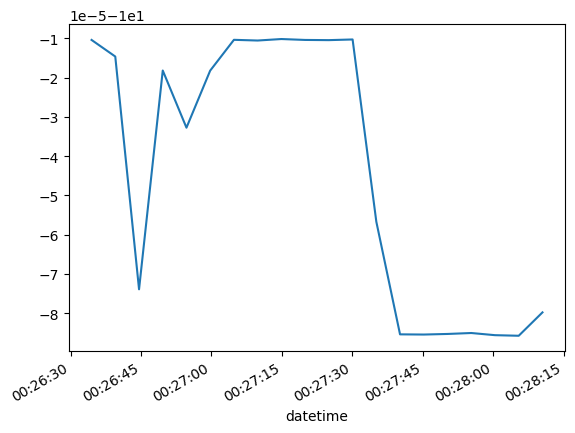

In [34]:
absolute_data_with_groups[absolute_data_with_groups['group'] == 26]['ag3458a_1_dcv'].plot()
display(analyse_group_quality(absolute_data_with_groups, 'ag3458a_1_dcv'))

Conclusion: Remove last sample for every group, with the logic that if a cable is disconnected during a sample, it may affect that sample without the script noticing the cable is disconnected, and drop group 26 (see plot). Also remove first sample for every group (see groups 11, 29, 30). Could have to do with warmth from hands on connectors causing thermal EMF.

Data quality with these changes:

In [33]:
absolute_data_first_and_last_in_group_removed = clean_groups(absolute_data_with_groups)
absolute_aggregate_data = aggregate_absolute_data_by_group(absolute_data_first_and_last_in_group_removed)
cleaned_absolute_data = absolute_aggregate_data[absolute_aggregate_data.index != 26]
display(cleaned_absolute_data)

ag3458a_1_dcv                                   temperature            \
               mean           std           sem count        mean       std   
group                                                                         
1         -9.999947  3.234127e-07  4.875629e-08    44   34.723677  0.003729   
2          9.999947  4.842913e-07  4.917233e-08    97   34.730928  0.007871   
3         10.000010  3.694474e-07  5.993229e-08    38   34.711487  0.004220   
4        -10.000010  2.276600e-07  3.693133e-08    38   34.794434  0.091118   
5         -9.999948  2.728817e-07  4.314639e-08    40   35.220703  0.079952   
6          9.999948  3.619987e-07  5.723702e-08    40   35.529795  0.036073   
7         10.000010  3.531643e-07  7.896993e-08    20   35.471025  0.019986   
8        -10.000010  3.813986e-07  8.749885e-08    19   35.381445  0.019278   
9         10.000159  3.803617e-07  1.098010e-07    12   35.281641  0.011695   
10       -10.000159  5.156976e-07  8.844141e-08    34   35.177194  0.032744   
11       -10.000010  3.140157e-07  7.616000e-08    17   35.082916  0.012655   
12        10.000011  3.160301e-07  7.664855e-08    17   35.003860  0.012646   
13         9.999773  3.753444e-07  8.190685e-08    21   34.962751  0.009064   
14        -9.999773  2.642077e-07  5.632928e-08    22   34.951625  0.004355   
15       -10.000010  3.189984e-07  5.043808e-08    40   34.911221  0.022655   
16        10.000010  3.370651e-07  7.355363e-08    21   34.808398  0.004622   
17        10.000186  2.755518e-07  5.624678e-08    24   34.823348  0.006837   
18       -10.000186  2.989469e-07  5.369245e-08    31   35.071554  0.084236   
19       -10.000009  2.767171e-07  5.534341e-08    25   35.379297  0.061690   
20        10.000009  3.882619e-07  5.787866e-08    45   35.541128  0.041497   
21        10.000012  4.024152e-07  5.933289e-08    46   35.265341  0.052568   
22       -10.000013  3.436354e-07  8.099564e-08    18   35.110232  0.014858   
23       -10.000010  3.538867e-07  7.913147e-08    20   35.072129  0.017620   
24        10.000010  4.005923e-07  5.087527e-08    62   35.417021  0.148324   
25        10.000010  3.552686e-07  7.251889e-08    24   35.658993  0.027789   
27       -10.000010  2.911431e-07  5.406391e-08    29   35.825114  0.051905   
28        10.000010  2.840425e-07  4.435998e-08    41   35.907379  0.065333   
29        10.000014  6.689176e-07  1.622363e-07    17   35.600942  0.017203   
30       -10.000011  3.026187e-07  7.132792e-08    18   35.474816  0.019368   
31       -10.000010  2.618130e-07  5.854317e-08    20   35.397402  0.013786   
32        10.000009  5.390621e-07  9.111812e-08    35   35.303650  0.024372   
33        10.000006  3.689616e-07  8.250231e-08    20   35.209209  0.021831   
34       -10.000006  4.168520e-07  7.877763e-08    28   35.141002  0.020762   
35       -10.000009  3.911769e-07  7.823537e-08    25   35.086180  0.016123   
36        10.000009  4.423701e-07  4.977052e-08    79   35.042689  0.006765   
37         9.999948  4.312789e-07  6.819118e-08    40   34.942114  0.027697   
38        -9.999948  2.819032e-07  4.249851e-08    44   34.864511  0.006175   

                            dut dut_setting  
            sem count      last        last  
group                                        
1      0.000562    44  F7001bat       -10 V  
2      0.000799    97  F7001bat        10 V  
3      0.000685    38  D4910avg        10 V  
4      0.014781    38  D4910avg       -10 V  
5      0.012642    40  F7001bat       -10 V  
6      0.005704    40  F7001bat        10 V  
7      0.004469    20  D4910avg        10 V  
8      0.004423    19  D4910avg       -10 V  
9      0.003376    12    F732a3        10 V  
10     0.005615    34    F732a3       -10 V  
11     0.003069    17  D4910avg       -10 V  
12     0.003067    17  D4910avg        10 V  
13     0.001978    21    F732a2        10 V  
14     0.000929    22    F732a2       -10 V  
15     0.003582    40  D4910avg       -10 V  
16     0.001008  

### Results

,dut,dcv_mean,dcv_sem,temperature_mean
dut_group_,,,,
1,F7001bat,9.999947,4.896475e-08,34.727303
2,D4910avg,10.000010,4.977852e-08,34.752961
3,F7001bat,9.999948,5.068376e-08,35.375249
4,D4910avg,10.000010,8.334356e-08,35.426235
5,F732a3,10.000159,9.969487e-08,35.229418
6,D4910avg,10.000011,7.640467e-08,35.043388
7,F732a2,9.999773,7.029125e-08,34.957188
8,D4910avg,10.000010,6.306400e-08,34.859810
9,F732a1,10.000186,5.498445e-08,34.947451


<AxesSubplot:xlabel='dut_group_'>

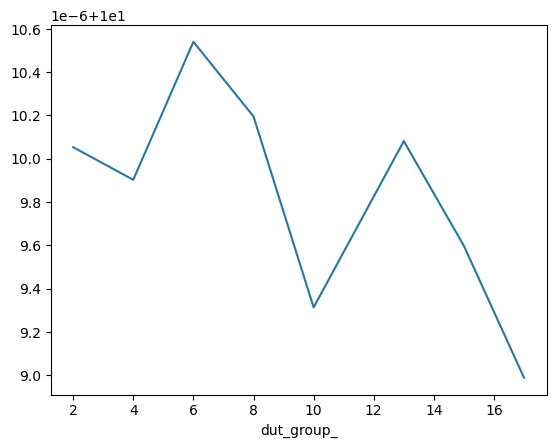

In [72]:
absolute_grouped_by_dut = aggregate_absolute_data_by_dut_group(cleaned_absolute_data)
display(absolute_grouped_by_dut)
absolute_grouped_by_dut[absolute_grouped_by_dut.dut == 'D4910avg']['dcv_mean'].plot()

In [73]:
absolute_results = absolute_grouped_by_dut.groupby('dut').agg({'dcv_mean': 'mean', 'dcv_sem': combine_stds_sum, 'temperature_mean': 'mean'})
display(absolute_results)

,dcv_mean,dcv_sem,temperature_mean
dut,,,
D4910-1,10.000013,7.099537e-08,35.187786
D4910-2,10.000010,6.857860e-08,35.382714
D4910-3,10.000013,1.253162e-07,35.537879
D4910-4,10.000006,8.066147e-08,35.175105
D4910avg,10.000010,6.619518e-08,35.227977
F7001bat,9.999948,5.226366e-08,35.001955
F732a1,10.000186,5.498445e-08,34.947451
F732a2,9.999773,7.029125e-08,34.957188
F732a3,10.000159,9.969487e-08,35.229418


#### Ratios

In [79]:
ratios_from_absolute = dcv_calculate_ratios(absolute_grouped_by_dut, 'D4910avg')
display(ratios_from_absolute)

,ratio,ratio_sem,temperature_mean
dut,,,
D4910-1,1.000000,9.081160e-09,35.187786
D4910-2,1.000000,8.454802e-09,35.382714
D4910-3,1.000000,1.409228e-08,35.537879
D4910-4,1.000000,1.076484e-08,35.175105
F7001bat,0.999994,8.210352e-09,35.095278
F732a1,1.000018,8.133355e-09,34.947451
F732a2,0.999976,9.923698e-09,34.957188
F732a3,1.000015,1.277933e-08,35.229418


# Relative data

In [80]:
relative_dcv_add_polarity(relative_data)
f7001_value = absolute_grouped_by_dut[absolute_grouped_by_dut.dut == 'F7001bat'][['dut', 'dcv_mean']].groupby('dut').mean().iloc[0, 0]
relative_results_in_ppm = relative_results_to_ppm(relative_data, f7001_value)
relative_results_in_ppm

,mean_in_ppm,sem_in_ppm
dut,,
D4910-1,6.774555,0.003903
D4910-2,6.581866,0.004512
D4910-3,6.952457,0.003510
D4910-4,6.178619,0.003344
D4910avg,6.484320,0.006513
F732a1,23.982767,0.002508
F732a2,-17.376850,0.001933
F732a3,21.272410,0.003114


# Comparison absolute vs relative

## Reference value of F7001

In [81]:
F7001bat_value = absolute_grouped_by_dut[absolute_grouped_by_dut.dut == 'F7001bat'].groupby('dut').agg({'dcv_mean': 'mean', 'dcv_sem': combine_stds_sum, 'temperature_mean': 'mean'})
D4910avg_value = absolute_grouped_by_dut[absolute_grouped_by_dut.dut == 'D4910avg'].groupby('dut').agg({'dcv_mean': 'mean', 'dcv_sem': combine_stds_sum, 'temperature_mean': 'mean'})
display(F7001bat_value)
display(D4910avg_value)

,dcv_mean,dcv_sem,temperature_mean
dut,,,
F7001bat,9.999948,5.226366e-08,35.001955


,dcv_mean,dcv_sem,temperature_mean
dut,,,
D4910avg,10.00001,6.619518e-08,35.227977


## Convert ratios back to absolute

In [82]:
ratios_to_absolute = ratios_from_absolute.copy().drop(['ratio', 'ratio_sem'], axis=1)
ratios_to_absolute['absolute'] = ratios_from_absolute.ratio * D4910avg_value.dcv_mean[0]
ratios_to_absolute['absolute_sem'] = combine_stds_ratio_product(ratios_from_absolute.ratio * D4910avg_value.dcv_mean[0], ratios_from_absolute.ratio, ratios_from_absolute.ratio_sem, D4910avg_value.dcv_mean[0], D4910avg_value.dcv_sem[0])
ratios_to_absolute.loc['D4910avg'] = (D4910avg_value.temperature_mean[0], D4910avg_value.dcv_mean[0], D4910avg_value.dcv_sem[0])
(ratios_to_absolute - F7001bat_value['dcv_mean'][0]) / 10 * 1e6
display(ratios_to_absolute)

,temperature_mean,absolute,absolute_sem
dut,,,
D4910-1,35.187786,10.000013,1.123769e-07
D4910-2,35.382714,10.000010,1.073787e-07
D4910-3,35.537879,10.000013,1.556955e-07
D4910-4,35.175105,10.000006,1.263724e-07
F7001bat,35.095278,9.999948,1.054644e-07
F732a1,34.947451,10.000186,1.048671e-07
F732a2,34.957188,9.999772,1.192878e-07
F732a3,35.229418,10.000159,1.439205e-07
D4910avg,35.227977,10.000010,6.619518e-08


## Convert absolute and ratio to ppm difference

In [84]:
ratios_ppm = ratios_to_absolute.copy().drop(['absolute', 'absolute_sem'], axis=1)
ratios_ppm['ppm_diff'] = (1-ratios_from_absolute.ratio) * 1e6
ratios_ppm['ppm_sem'] = ratios_from_absolute.ratio_sem * 1e6

In [85]:
ratios_ppm

,temperature_mean,ppm_diff,ppm_sem
dut,,,
D4910-1,35.187786,-0.353626,0.009081
D4910-2,35.382714,0.003688,0.008455
D4910-3,35.537879,-0.299481,0.014092
D4910-4,35.175105,0.349743,0.010765
F7001bat,35.095278,6.204112,0.008210
F732a1,34.947451,-17.648101,0.008133
F732a2,34.957188,23.755563,0.009924
F732a3,35.229418,-14.898526,0.012779
D4910avg,35.227977,NaN,NaN


In [222]:
absolute_ppm = absolute_results.copy().drop(['dcv_mean', 'dcv_sem'], axis=1)
absolute_ppm['ppm_diff_abs'] = (absolute_results.dcv_mean - absolute_results.loc['F7001bat', 'dcv_mean']) / 10 * 1e6
absolute_ppm['ppm_sem_abs'] = np.sqrt(absolute_results.dcv_sem**2 + absolute_results.loc['F7001bat', 'dcv_sem']**2) / 10 * 1e6
display(absolute_ppm)

,temperature_mean,ppm_diff_abs,ppm_sem_abs
dut,,,
D4910-1,35.189528,6.515092,0.008503
D4910-2,35.381576,6.234933,0.008540
D4910-3,35.539758,6.517044,0.012951
D4910-4,35.176569,5.812728,0.009250
D4910avg,35.228083,6.214768,0.008124
F7001bat,35.001177,0.000000,0.006776
F732a1,34.945120,23.854850,0.007187
F732a2,34.957431,-17.488748,0.008761
F732a3,35.231007,21.151138,0.011583


## Combining the three methods

In [90]:
combined = ratios_ppm.join(relative_results_in_ppm)
combined.columns = ['temperature', 'abs_mean', 'abs_sem', 'rel_mean', 'rel_sem']
combined

,temperature,abs_mean,abs_sem,rel_mean,rel_sem
dut,,,,,
D4910-1,35.187786,-0.353626,0.009081,6.774555,0.003903
D4910-2,35.382714,0.003688,0.008455,6.581866,0.004512
D4910-3,35.537879,-0.299481,0.014092,6.952457,0.003510
D4910-4,35.175105,0.349743,0.010765,6.178619,0.003344
F7001bat,35.095278,6.204112,0.008210,NaN,NaN
F732a1,34.947451,-17.648101,0.008133,23.982767,0.002508
F732a2,34.957188,23.755563,0.009924,-17.376850,0.001933
F732a3,35.229418,-14.898526,0.012779,21.272410,0.003114
D4910avg,35.227977,NaN,NaN,6.484320,0.006513


# Comparison to previous comparisons

In [120]:
relative_results_in_ppm[relative_results_in_ppm.index == 'D4910avg'].mean_in_ppm.iloc[0]

6.484319935448829

In [131]:
pd.concat([relative_results_in_ppm, pd.DataFrame({'mean_in_ppm': 0, 'sem_in_ppm': 0}, index=('hi',))])

,mean_in_ppm,sem_in_ppm
D4910-1,6.774555,0.003903
D4910-2,6.581866,0.004512
D4910-3,6.952457,0.003510
D4910-4,6.178619,0.003344
D4910avg,6.484320,0.006513
F732a1,0.000000,0.000000
F732a2,-17.376850,0.001933
F732a3,21.272410,0.003114
hi,0.000000,0.000000
